# YouTube trending videos

In [93]:
import os
from typing import List


# import sys
# sys.path.append('..')

import numpy as np
from numpy import nan
nan
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats

from helpers.files import load_csv, load_csv_file
from helpers.json_helper import load_tokenized_text
from ped5.tfidf import add_tfidf_args



numeric_attrs = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day", "publish_time", "movie_domains_count"
]

bool_attrs = [
    "comments_disabled", "ratings_disabled", "video_error_or_removed"
]

## Etap 5 - Zbieranie danych nie-trending

### Skrypt do zbierania danych trending

Pierwszym krokiem, który został wykonany w ramach tego etapu było
zapoznanie się z oryginalnym skryptem do pobierania danych „trending".
Skrypt jest dostępny w repozytorium [Trending-Youtube-Scraper](https://github.com/mitchelljy/Trending-YouTube-Scraper).

Oryginalny skrypt do pobierania danych pobierał filmy z sekcji trending dla danego
dnia, którym był dzień uruchomienia skryptu. Kilka atrybutów np. *trending date*, było
tworzone w ramach skryptu na podstawie danych pobranych z api.
W celu ujednolicenia sposobu tworzenia atrybutów zostało to uwzględnione podczas
pisania skryptu do pobrania danych nie trending.


### Pomysł na pobranie danych nie trending

Podczas wysyłania żądań do interfejsu api serwisu YouTube zostały przyjęte
następujące założenia:
- Pobieranie filmów dla dwóch krajów osobno GB i US (parametr *region_code*).
- Filtrowanie danych po kategoriach, w zbiorze znajdują się tylko
kategorie występujące w oryginalnym zbiorze danych.
- Podczas pobierania danych starano się zachować oryginalne dysproporcje między
kategoriami, z jakich pochodziły filmy.
- 11.2017-07.2018 - okres, w którym film musiał zostać opublikowany,
wybrany na podstawie danych trending.
- Dodatkowo w wyżej wymieniony zakres czasu został podzielony na
4 podokresy, w celu bardziej jednorodnego rozłożenia czasów publikacji.
- Kolejnym ważnym aspektem było sprawdzanie, czy dany film nie pojawił się
w zbiorze danych, do filtrowania służył atrybut *video_id*.
- Do zbioru danych nie zostały dopuszczane duplikaty.

Po etapie wyszukiwania filmów w zbiorze danych zostały uzupełnione brakujące
atrybuty część z nich jak statystyki dotyczące wyświetleń, polubień, komentarzy
wymagały wygenerowania kolejnych żądań. Pozostałe przetwarzanie, np. tokenizacja
atrybutów tekstowych, przygotowanie atrybutów czasowych zostały dokonane lokalnie.

### Wczytanie danych trending

In [94]:
gb_videos, us_videos = load_csv("ped3_data")
trending_videos = pd.concat([gb_videos, us_videos])

for name in numeric_attrs:
    trending_videos[name] = trending_videos[name].apply(lambda x: eval(x)[-1] if eval(x) else np.nan)
trending_videos["tags"] = trending_videos["tags"].apply(lambda x: eval(x)[-1] if eval(x) else np.nan)

for name in bool_attrs:
    trending_videos[name] = trending_videos[name].apply(lambda x: eval(x)[-1] if eval(x) else np.nan)

### Wczytanie danych nie trending

In [95]:
gb_non_videos, us_non_videos = load_csv("ped5_non_trending")
non_trending_videos = pd.concat([gb_non_videos, us_non_videos])
non_trending_videos.rename(columns={"category_id": "new_category_id"}, inplace=True)

### Atrybuty liczbowe

**Funkcja do rysowania wykresów**

In [96]:
def plot_numeric_attr(attr_name: str, trending: pd.DataFrame, non_trending: pd.DataFrame) -> None:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
    axes[0, 0].hist(trending[attr_name])
    axes[0, 0].title.set_text(f"Trending: {attr_name}")
    axes[0, 1].hist(non_trending[attr_name])
    axes[0, 1].title.set_text(f"Non Trending: {attr_name}")
    axes[1, 0].boxplot(
        [trending[trending[attr_name].notna()][attr_name], non_trending[attr_name]],
        labels=["Trending", "Non Trending"]
    )
    axes[1, 1].boxplot(
        [trending[trending[attr_name].notna()][attr_name], non_trending[attr_name]],
        labels=["Trending", "Non Trending"],
        showfliers=False
    )

**Views**

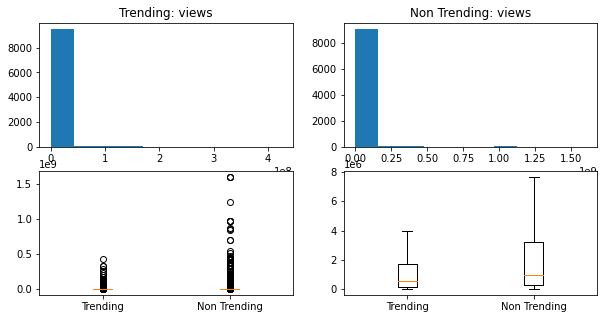

In [97]:
plot_numeric_attr("views", trending_videos, non_trending_videos)

**Likes**

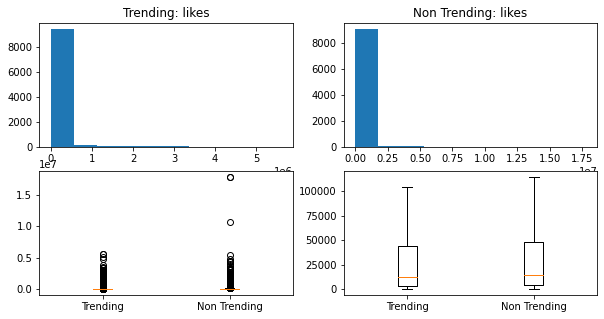

In [98]:
plot_numeric_attr("likes", trending_videos, non_trending_videos)

**Dislikes**

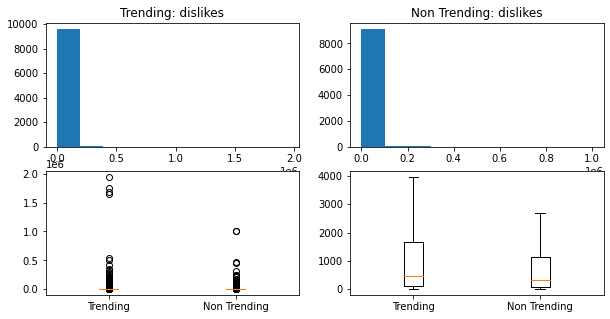

In [99]:
plot_numeric_attr("dislikes", trending_videos, non_trending_videos)

**Comment Count**

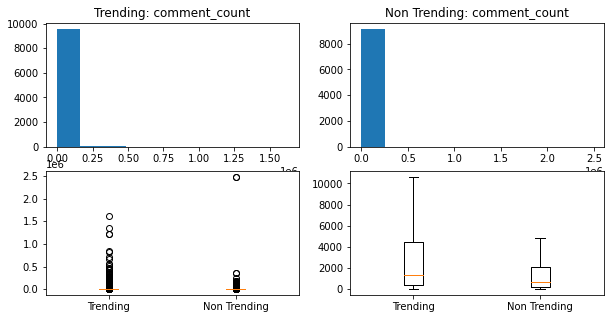

In [100]:
plot_numeric_attr("comment_count", trending_videos, non_trending_videos)

**Description length**

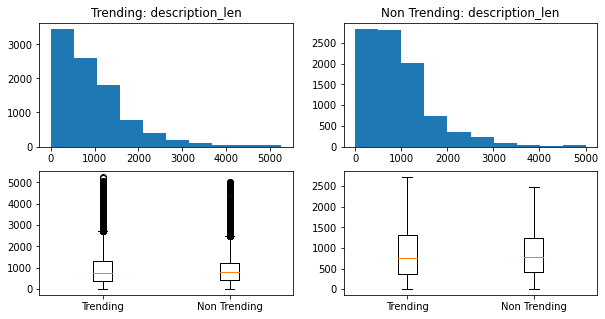

In [101]:
plot_numeric_attr("description_len", trending_videos, non_trending_videos)

**Title length**

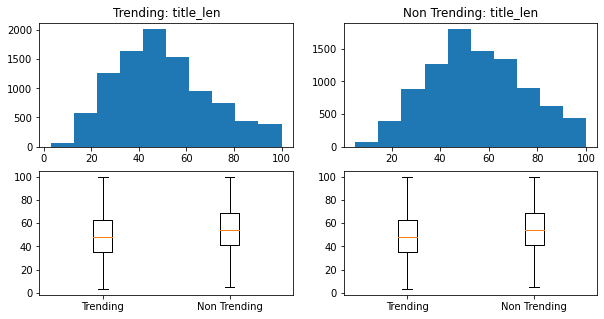

In [102]:
plot_numeric_attr("title_len", trending_videos, non_trending_videos)

**Channel title length**

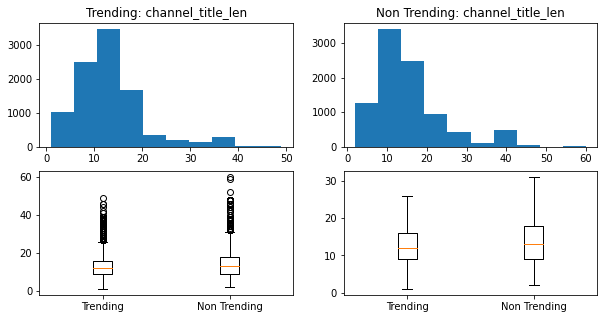

In [103]:
plot_numeric_attr("channel_title_len", trending_videos, non_trending_videos)

**Liczba linków**

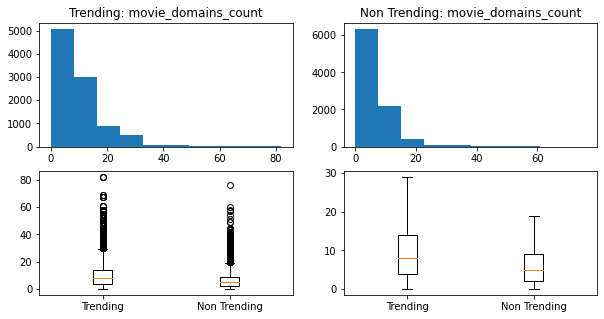

In [104]:
plot_numeric_attr("movie_domains_count", trending_videos, non_trending_videos)

### Atrybuty czasowe

**Dzień opublikowania filmu**

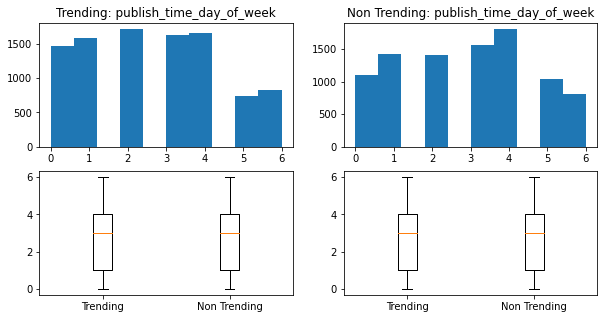

In [105]:
plot_numeric_attr("publish_time_day_of_week", trending_videos, non_trending_videos, )

**Godzina opublikowania filmu**

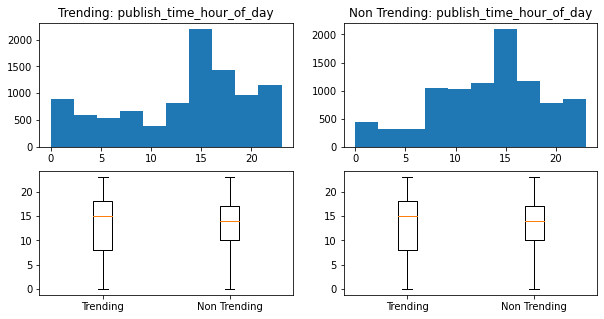

In [106]:
plot_numeric_attr("publish_time_hour_of_day", trending_videos, non_trending_videos)

**Data publikacji**

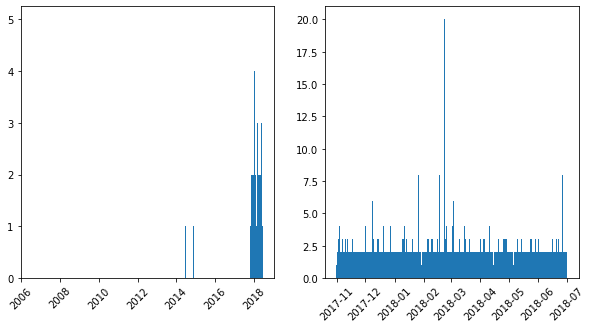

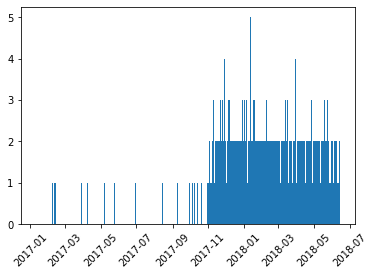

In [107]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

trending_publish_time_counts = pd.to_datetime(trending_videos["publish_time"],
                                              format="%Y-%m-%dT%H:%M:%S.%fZ").value_counts()
trending_publish_time_counts = trending_publish_time_counts.rename_axis("publish_time").reset_index(name="count")

publish_times = pd.to_datetime(trending_videos["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ")
filtered = publish_times[publish_times >= "2017-01-01"]
filtered_counts = filtered.value_counts().rename_axis("publish_time").reset_index(name="count")

non_trending_publish_time_counts = pd.to_datetime(non_trending_videos["publish_time"],
                                                  format="%Y-%m-%dT%H:%M:%SZ").value_counts()
non_trending_publish_time_counts = non_trending_publish_time_counts.rename_axis("publish_time").reset_index(
    name="count")

axes[0].bar(pd.to_datetime(trending_publish_time_counts["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ"),
            trending_publish_time_counts["count"])
for tick in axes[0].get_xticklabels():
    tick.set_rotation(45)

axes[1].bar(pd.to_datetime(non_trending_publish_time_counts["publish_time"], format="%Y-%m-%dT%H:%M:%SZ"),
            non_trending_publish_time_counts["count"])
for tick in axes[1].get_xticklabels():
    tick.set_rotation(45)
plt.show()

plt.bar(pd.to_datetime(filtered_counts["publish_time"], format="%Y-%m-%dT%H:%M:%S.%fZ"), filtered_counts["count"])
plt.xticks(rotation=45)
plt.show()

### Atrybuty binarne

**Funkcja do rysowania wykresów**

In [108]:
def plot_bool_attr(attr_name:str) -> None:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    trending_values_counts = trending_videos[attr_name].value_counts().rename_axis("value").reset_index(name="count")
    axes[0].bar(np.arange(len(trending_values_counts)), trending_values_counts["count"])
    axes[0].set_xticks(np.arange(len(trending_values_counts)))
    axes[0].set_xticklabels(["False", "True"])
    axes[0].title.set_text(f"Trending: {attr_name}")
    non_trending_values_counts = non_trending_videos[attr_name].value_counts().rename_axis("value").reset_index(name="count")
    axes[1].bar(np.arange(len(non_trending_values_counts)), non_trending_values_counts["count"])
    axes[1].set_xticks(np.arange(len(non_trending_values_counts)))
    axes[1].set_xticklabels(["False", "True"])
    axes[1].title.set_text(f"Non Trending: {attr_name}")

**Zablokowanie komentowania - comments disabled**

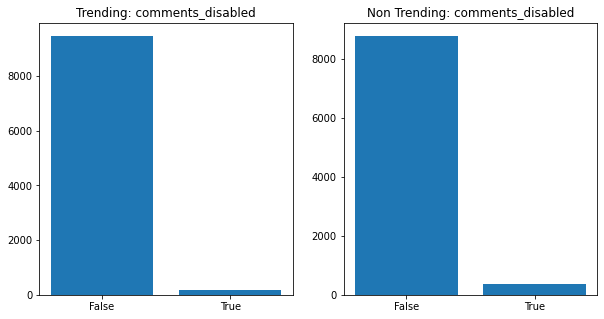

In [109]:
plot_bool_attr("comments_disabled")

**Zablokowanie oceny - ratings disabled**

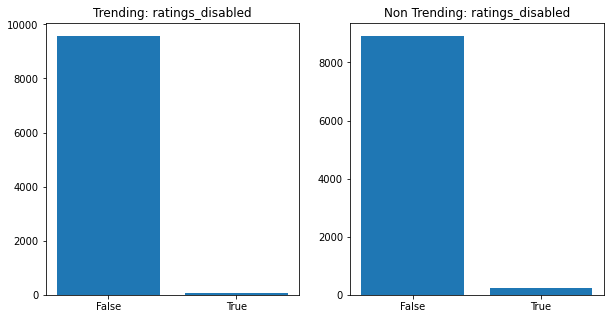

In [110]:
plot_bool_attr("ratings_disabled")

**Błąd filmu lub usunięty - video error or removed**

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (2).

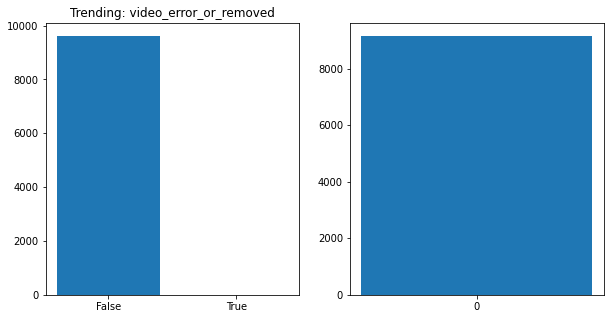

In [111]:
plot_bool_attr("video_error_or_removed")

### Atrybuty tekstowe

**Metoda do wyświetlania wykresów**

In [ ]:
def plot_tokenized_stats(attr_name):
    us_tokens = load_tokenized_text(f"US_grouped_{attr_name}s")
    gb_tokens = load_tokenized_text(f"GB_grouped_{attr_name}s")
    trending_tokens = []
    trending_words = []
    for i, tokens_list in enumerate(gb_tokens + us_tokens):
        if len(tokens_list) > 0:
            trending_tokens.append(tokens_list[0])
            trending_words += tokens_list[0]
        else:
            trending_tokens.append([])
    trending_words = pd.DataFrame(data={"words": trending_words})
    trending_values_counts = trending_words.value_counts().rename_axis("words").reset_index(name="count")
    tr_head = trending_values_counts.head(50)
    non_trending_path = os.path.join("non_trending", "words")

    gb_non_words = load_csv_file(os.path.join(non_trending_path, f"GB_{attr_name}.csv"))
    us_non_words = load_csv_file(os.path.join(non_trending_path, f"US_{attr_name}.csv"))
    non_trending_words = pd.concat([gb_non_words, us_non_words])
    non_trending_values_counts = non_trending_words.value_counts().rename_axis("words").reset_index(name="count")
    non_tr_head = non_trending_values_counts.head(50)

    plt.subplots(figsize=(18, 5))
    plt.bar(tr_head["words"], tr_head["count"])
    plt.title("Trending")
    plt.xticks(rotation=270, fontsize=15)
    plt.show()

    plt.subplots(figsize=(18, 5))
    plt.bar(non_tr_head["words"], non_tr_head["count"])
    plt.title("Non Trending")
    plt.xticks(rotation=270, fontsize=15)
    plt.show()

**Tytuły kanałów - channel_title**

In [ ]:
plot_tokenized_stats("channel_title")

**Tytuły filmów - title**

In [ ]:
plot_tokenized_stats("title")

**Opisy filmów - description**

In [ ]:
plot_tokenized_stats("description")

**Domeny**

In [ ]:
plot_tokenized_stats("domain")

**Tagi**

In [ ]:
def prepare_tags(tags):
    tags.index = tags.index.droplevel(-1)
    tags.name = "tags"
    tags = tags.to_frame()
    tags_counts = tags.value_counts()
    tags_counts = tags_counts.rename_axis("tag").reset_index(name="count")
    return tags_counts


non_trending_tags = non_trending_videos["tags"].str.split("|").apply(pd.Series, 1).stack()
trending_tags = trending_videos["tags"].str.split("|").apply(pd.Series, 1).stack()

non_trending_tags = prepare_tags(non_trending_tags)
trending_tags = prepare_tags(trending_tags)

plt.subplots(figsize=(18, 5))
plt.bar(trending_tags["tag"].head(50), trending_tags["count"].head(50))
plt.title("Trending")
plt.xticks(rotation=270, fontsize=15)
plt.show()

plt.subplots(figsize=(18, 5))
plt.bar(non_trending_tags["tag"].head(50), non_trending_tags["count"].head(50))
plt.title("Non Trending")
plt.xticks(rotation=270, fontsize=15)
plt.show()

### Podsumowanie wykresów

Podczas analizy danych trending vs non trending, został zauważony pewien problem,
ponieważ dane pochodziły z konkretnych dni z lat 2017-2018, jednak pobierane statystyki
dla danych non trending pochodzą z roku 2021. To tłumaczyłoby anomalie takie jak np. wyższe
liczby wyświetleń w filmach non trending. W celu wyeliminowania tego problemu
przeprowadzona została także analiza z nowo pobranymi statystykami filmów trending.

### Wczytanie odświeżonych danych trending

In [ ]:
gb_videos, us_videos = load_csv("ped5_trending")
trending_videos = pd.concat([gb_videos, us_videos])
trending_videos.rename(columns={"category_id": "new_category_id"}, inplace=True)

**Views**

In [ ]:
plot_numeric_attr("views", trending_videos, non_trending_videos)

**Likes**

In [ ]:
plot_numeric_attr("likes", trending_videos, non_trending_videos)

**Dislikes**

In [ ]:
plot_numeric_attr("dislikes", trending_videos, non_trending_videos)

**Comment Count**

In [ ]:
plot_numeric_attr("comment_count", trending_videos, non_trending_videos)

**Description length**

In [ ]:
plot_numeric_attr("description_len", trending_videos, non_trending_videos)

**Title length**

In [ ]:
plot_numeric_attr("title_len", trending_videos, non_trending_videos)

**Channel title length**

In [ ]:
plot_numeric_attr("channel_title_len", trending_videos, non_trending_videos)

**Liczba linków**

In [ ]:
plot_numeric_attr("movie_domains_count", trending_videos, non_trending_videos)

## Ocena atrybutów


### Atrybuty numeryczne

Korelacja atrybutów liczbowych z klasą decyzyjną trending czy nietrending

Atrybuty numeryczne zostały ocenione za pomocą analizy wariancji (ANOVA Analysis of Variance).
Zastosowana metoda wynika z tego, że mamy jednym z atrybutów jest atrybut
nominalny - klasę decyzyjną trending vs non trending.

Przyjęte hipotezy:

$$ H_0 $$: Średnie w poszczególnych grupach są takie same.

$$ H_1 $$: Średnie w poszczególnych grupach są różne.


Przyjęty poziom istotności: $$ \alpha = 0.05 $$

In [ ]:

numeric_attrs = [
    "views", "likes", "dislikes", "comment_count", "description_len", "title_len", "channel_title_len",
    "publish_time_day_of_week", "publish_time_hour_of_day"
]


def anova(data: List[pd.DataFrame], attr: str, show_plots: bool = True):
    data_set = list(map(lambda x: x[attr].dropna(), data))
    f_score, p_value = stats.f_oneway(
        *data_set
    )
    print(f"{attr}: f_score = {f_score} p_value = {p_value}")
    if show_plots:
        plt.title(attr)
        plt.boxplot(data_set, showfliers=False)
        labels = ["Trending", "Non Trending"]
        plt.xticks(np.arange(1, len(labels) + 1), labels, rotation=270, fontsize=15)
        plt.show()
    return f_score, p_value



In [ ]:
data_set = [trending_videos, non_trending_videos]

f_scores = pd.DataFrame()
alpha = 0.05
for i in numeric_attrs:
    f, p = anova(data_set, i)
    f_scores = f_scores.append(pd.DataFrame(
        data={"attr": [i], "f score": [f], "p value": [p], "leq alpha": [p <= alpha]}
    ), ignore_index=True)
f_scores

### Atrybuty liczbowe wyekstrahowane z cech obrazków

Liczone są analogicznie jak poprzednich etapach. Najpierw wczytywane są już przeliczone dane, a następnie za pomocą anovy liczona jest istotność statystyczna.

In [ ]:
images_data_cols = ["gray_mean_score","color_mean_score", "gray_hist_score", "red_hist_score", "green_hist_score", "blue_hist_score",
                    "edges_score", "entropy_score"]
gb_videos_img, us_videos_img = load_csv("ped3_data")
trending_videos_img = pd.concat([gb_videos_img, us_videos_img])

non_trending_videos_img = load_csv("images_data_non_trending")[0]

In [ ]:
data_set = [trending_videos_img, non_trending_videos_img]

f_scores_img = pd.DataFrame()
alpha = 0.05
for i in images_data_cols:
    f, p = anova(data_set, i)
    f_scores_img = f_scores_img.append(pd.DataFrame(
        data={"attr": [i], "f score": [f], "p value": [p], "leq alpha": [p <= alpha]}
    ), ignore_index=True)
f_scores_img

Spośród atyrbutów z obrazków, można zauważyć że okoła połowa z nich może okazać się pomocna w klasyfkacji do podziału trending/non_trending, gdzie najbardziej istotny zdaje się być informacja o krawędziach, co można częściowo interpretować jako liczbę różnych obiektów na obrazku

### Ocena atrybutów tekstowych

W przypadku atrybutów tekstowych zdecydowaliśmy się użyć reprezentacji TF-IDF

In [ ]:
n_features = 20

**Tytuły - title**

In [ ]:
title_tfidf, f_names = add_tfidf_args("title", n_features)
trending_tfidf = title_tfidf[:len(trending_videos)]
non_trending_tfidf = title_tfidf[len(trending_videos):]

f_scores = pd.DataFrame()
for i in range(n_features):
    data_set = [trending_tfidf[i], non_trending_tfidf[i]]
    f_score, p_value = stats.f_oneway(
        *data_set
    )
    f_scores = f_scores.append(pd.DataFrame(
        data={"attr": [f_names[i]], "f score": [f_score], "p value": [p_value], "leq alpha": [p_value <= alpha]}
    ), ignore_index=True)
f_scores

**Tytuły kanałów - channel_title**

In [ ]:
channel_title_tfidf, f_names = add_tfidf_args("channel_title", n_features)
trending_tfidf = channel_title_tfidf[:len(trending_videos)]
non_trending_tfidf = channel_title_tfidf[len(trending_videos):]

f_scores = pd.DataFrame()
for i in range(n_features):
    data_set = [trending_tfidf[i], non_trending_tfidf[i]]
    f_score, p_value = stats.f_oneway(
        *data_set
    )
    f_scores = f_scores.append(pd.DataFrame(
        data={"attr": [f_names[i]], "f score": [f_score], "p value": [p_value], "leq alpha": [p_value <= alpha]}
    ), ignore_index=True)
f_scores

**Opisy - description**

In [ ]:
description_tfidf, f_names = add_tfidf_args("description", n_features)
trending_tfidf = description_tfidf[:len(trending_videos)]
non_trending_tfidf = description_tfidf[len(trending_videos):]

f_scores = pd.DataFrame()
for i in range(n_features):
    data_set = [trending_tfidf[i], non_trending_tfidf[i]]
    f_score, p_value = stats.f_oneway(
        *data_set
    )
    f_scores = f_scores.append(pd.DataFrame(
        data={"attr": [f_names[i]], "f score": [f_score], "p value": [p_value], "leq alpha": [p_value <= alpha]}
    ), ignore_index=True)
f_scores

**Tagi - tags**

In [ ]:
tags_tfidf, f_names = add_tfidf_args("tags", n_features)
trending_tfidf = tags_tfidf[:len(trending_videos)]
non_trending_tfidf = tags_tfidf[len(trending_videos):]
f_scores = pd.DataFrame()
for i in range(n_features):
    data_set = [trending_tfidf[i], non_trending_tfidf[i]]
    f_score, p_value = stats.f_oneway(
        *data_set
    )
    f_scores = f_scores.append(pd.DataFrame(
        data={"attr": [f_names[i]], "f score": [f_score], "p value": [p_value], "leq alpha": [p_value <= alpha]}
    ), ignore_index=True)
f_scores

